In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator

In [2]:
RESULTS_PATH = os.path.join("benchmark", "results", "results.csv")

In [3]:
df = pd.read_csv(RESULTS_PATH)
df['version'].values

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  16,  17,  16,  17,  18,  19,  20,  21,  22,
        23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
        36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
        49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
        62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,
        75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,
        88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
       101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
       127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
       153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
       166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 17

In [4]:
mask = (df['score_thresh'] == 0.05) & (df['iou_thresh'] == 0.25) & (df['rgem_pr'] == 2.5) & (df['min_area'] == 0.0)  & (df['min_sim_db'] == 0.0)
columns = ['detector_file', 'extractor_onnx_file', 'pipeline_onnx_file', 'image_dim', 'allowed_classes','scales', 'mean', 'std',
           'mp@1_easy_bbox', 'mp@5_easy_bbox', 'mp@10_easy_bbox', 'mp@1_medium_bbox', 'mp@5_medium_bbox', 'mp@10_medium_bbox',
           'mp@1_hard_bbox', 'mp@5_hard_bbox', 'mp@10_hard_bbox', 'map_easy_bbox', 'map_medium_bbox', 'map_hard_bbox', 'inference_time', 'keep_full_img',
           'sgem_infinity', 'eps', 'min_sim_db'
          ]
mask_c = df.columns[~df.columns.isin(columns)]
df[mask_c][mask]

,version,min_area,score_thresh,iou_thresh,rgem_pr,rgem_size,gem_p,sgem_ps,map_easy,mp@1_easy,mp@5_easy,mp@10_easy,map_medium,mp@1_medium,mp@5_medium,mp@10_medium,map_hard,mp@1_hard,mp@5_hard,mp@10_hard
0,0,0.0,0.05,0.25,2.5,5,4.6,10.0,75.487132,97.058824,84.044118,78.455882,58.685715,95.714286,81.809524,77.190476,30.344432,64.285714,53.428571,44.142857
226,223,0.0,0.05,0.25,2.5,5,4.6,10.0,88.189083,97.142857,94.952381,93.380952,76.668265,98.571429,97.714286,97.285714,55.086748,92.857143,92.000000,89.428571


In [5]:
# TEST min_sim_db
versions = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
df_min_sim_db = df[df['version'].isin(versions)]
df_min_sim_db.sort_values('min_sim_db', inplace=True)

C:\Users\rdiaz\AppData\Local\Temp\ipykernel_19328\1836878802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_min_sim_db.sort_values('min_sim_db', inplace=True)


In [6]:
columns = [
    'min_sim_db', 'keep_full_img', 
    'map_easy', 'map_medium', 'map_hard', 
    'mp@1_easy', 'mp@1_medium', 'mp@1_hard', 
    'mp@5_easy', 'mp@5_medium', 'mp@5_hard', 
    'mp@10_easy', 'mp@10_medium', 'mp@10_hard',
    'map_easy_bbox', 'map_medium_bbox', 'map_hard_bbox', 
    'mp@1_easy_bbox', 'mp@1_medium_bbox', 'mp@1_hard_bbox', 
    'mp@5_easy_bbox', 'mp@5_medium_bbox', 'mp@5_hard_bbox', 
    'mp@10_easy_bbox', 'mp@10_medium_bbox', 'mp@10_hard_bbox'
]
df_min_sim_db = df_min_sim_db[columns]

In [7]:
# Paso 1: separar por valor de keep_full_img
df_0 = df_min_sim_db[df_min_sim_db['keep_full_img'] == 0].copy()
df_1 = df_min_sim_db[df_min_sim_db['keep_full_img'] == 1].copy()

# Paso 2: renombrar columnas métricas en df_1
metric_cols = [col for col in df.columns if col not in ['min_sim_db', 'keep_full_img']]
df_1 = df_1.rename(columns={col: f"{col}_keep_full" for col in metric_cols})

# Paso 3: hacer merge por min_sim_db
df_min_sim_db_merged = pd.merge(df_0, df_1, on='min_sim_db', how='outer')

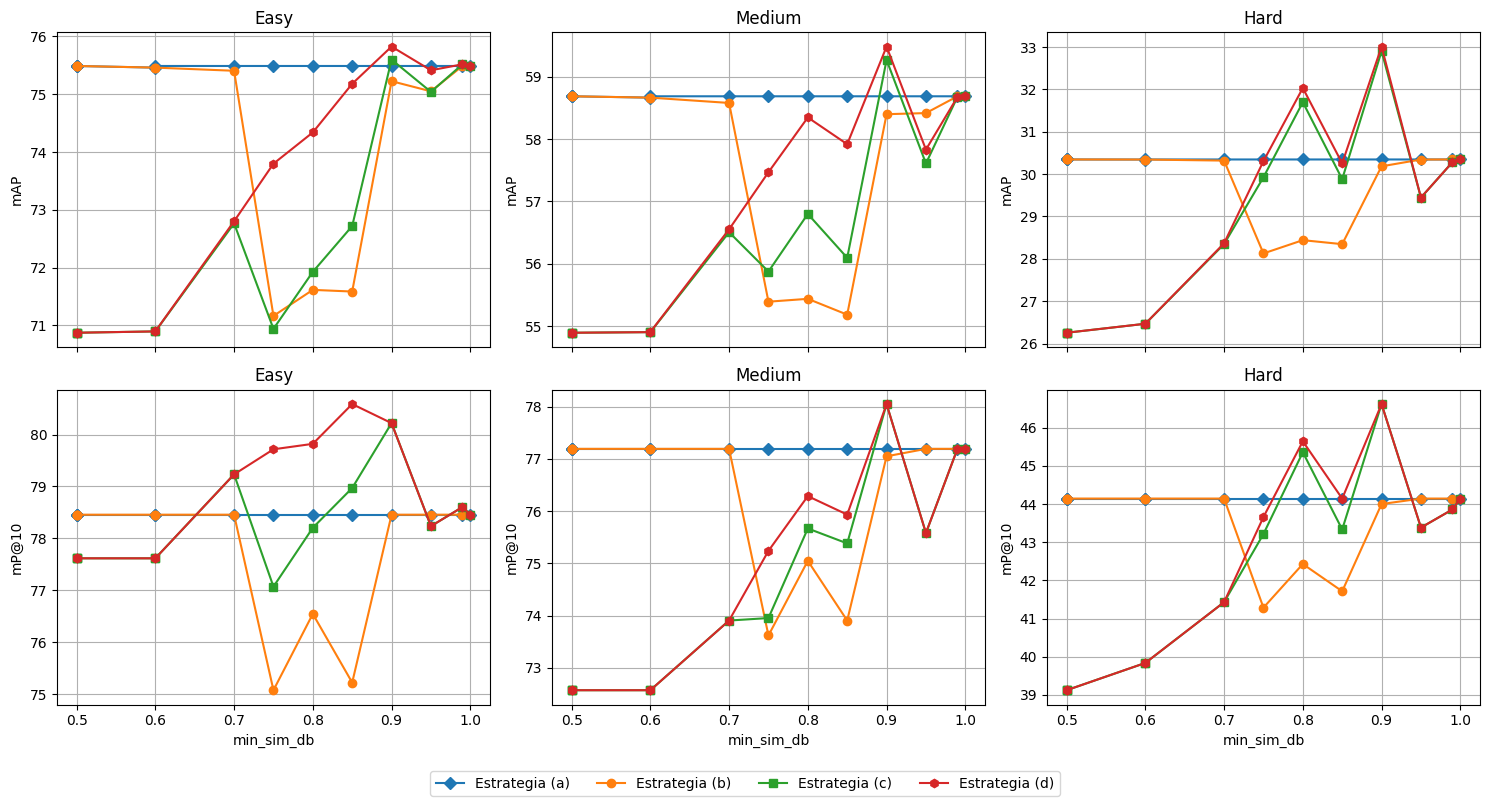

In [8]:
# Definir configuración de las métricas por nivel de dificultad
metrics = [
    ('map_easy', 'map_easy_bbox', 'map_easy_keep_full', 'map_easy_bbox_keep_full', 'Easy'),
    ('map_medium', 'map_medium_bbox', 'map_medium_keep_full', 'map_medium_bbox_keep_full', 'Medium'),
    ('map_hard', 'map_hard_bbox', 'map_hard_keep_full', 'map_hard_bbox_keep_full', 'Hard'),
    ('mp@10_easy', 'mp@10_easy_bbox', 'mp@10_easy_keep_full', 'mp@10_easy_bbox_keep_full', 'Easy'),
    ('mp@10_medium', 'mp@10_medium_bbox', 'mp@10_medium_keep_full', 'mp@10_medium_bbox_keep_full', 'Medium'),
    ('mp@10_hard', 'mp@10_hard_bbox', 'mp@10_hard_keep_full', 'mp@10_hard_bbox_keep_full', 'Hard')
]

# Crear subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 8), sharex=True, sharey=False)

for i, (ax, (col1, col2, col3, col4, title)) in enumerate(zip(axs.flat, metrics)):
    df_min_sim_db_merged.plot(x='min_sim_db', y=col3, ax=ax, label='Estrategia (a)', marker='D', legend=False)
    df_min_sim_db_merged.plot(x='min_sim_db', y=col1, ax=ax, label='Estrategia (b)', marker='o', legend=False)
    df_min_sim_db_merged.plot(x='min_sim_db', y=col2, ax=ax, label='Estrategia (c)', marker='s', legend=False)
    df_min_sim_db_merged.plot(x='min_sim_db', y=col4, ax=ax, label='Estrategia (d)', marker='h', legend=False)
    ax.set_title(title)
    ax.set_xlabel('min_sim_db')
    if i < 3:
        ax.set_ylabel('mAP')
    else:
        ax.set_ylabel('mP@10')
    ax.grid(True)

# Obtener handles y labels de cualquier eje (todos tienen los mismos)
handles, labels = axs[0, 0].get_legend_handles_labels()

# Colocar la leyenda una vez fuera del grid
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.02))

# plt.suptitle('Similitud mínima para la base de datos', fontsize=16, y=1.01)
plt.tight_layout(rect=[0, 0.03, 1, 0.99])

# Guardar como imagen PNG (puedes cambiar el nombre o ruta si deseas)
plt.savefig('min_sim_db_graph.png', dpi=300, bbox_inches='tight')

plt.show()

In [9]:
# TEST min_area
versions = [22, 27, 28, 31, 32, 35, 36, 38, 39, 40, 41, 43]
df_min_area = df[df['version'].isin(versions)]
df_min_area.sort_values('min_area', inplace=True)

C:\Users\rdiaz\AppData\Local\Temp\ipykernel_19328\4186622158.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_min_area.sort_values('min_area', inplace=True)


In [10]:
columns = [
    'version',
    'min_area', 
    'map_easy_bbox', 'map_medium_bbox', 'map_hard_bbox', 
    'mp@1_easy_bbox', 'mp@1_medium_bbox', 'mp@1_hard_bbox', 
    'mp@5_easy_bbox', 'mp@5_medium_bbox', 'mp@5_hard_bbox', 
    'mp@10_easy_bbox', 'mp@10_medium_bbox', 'mp@10_hard_bbox'
]
df_min_area = df_min_area[columns]

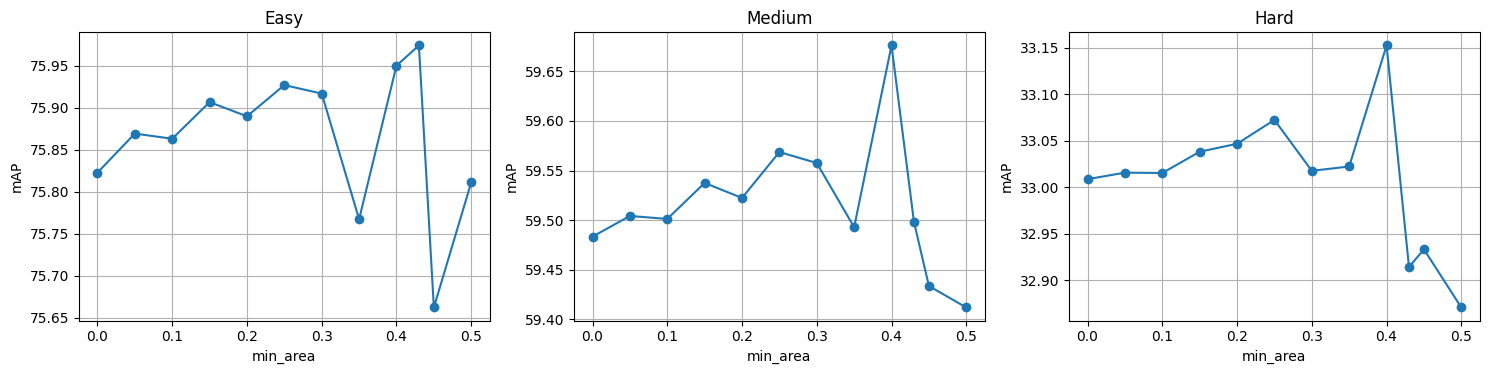

In [11]:
# Definir configuración de las métricas por nivel de dificultad
metrics = [
    ('map_easy_bbox', 'Easy'),
    ('map_medium_bbox', 'Medium'),
    ('map_hard_bbox', 'Hard'),
    ('mp@1_easy_bbox', 'Easy'),
    ('mp@1_medium_bbox', 'Medium'),
    ('mp@1_hard_bbox', 'Hard'),
    ('mp@5_easy_bbox', 'Easy'),
    ('mp@5_medium_bbox', 'Medium'),
    ('mp@5_hard_bbox', 'Hard'),
    ('mp@10_easy_bbox', 'Easy'),
    ('mp@10_medium_bbox', 'Medium'),
    ('mp@10_hard_bbox', 'Hard')
]
metrics = [
    ('map_easy_bbox', 'map_easy_bbox', 'map_easy_bbox', 'Easy'),
    ('map_medium_bbox', 'map_medium_bbox', 'map_medium_bbox', 'Medium'),
    ('map_hard_bbox', 'map_hard_bbox', 'map_hard_bbox', 'Hard'),
]

# Crear subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), sharex=True, sharey=False)

for i, (ax, (col1, col2, col3, title)) in enumerate(zip(axs.flat, metrics)):
    ax.set_title(title)
    ax.set_xlabel('min_area')
    if i < 3:
        df_min_area.plot(x='min_area', y=col1, ax=ax, label='mAP', marker='o', legend=False)
        ax.set_ylabel('mAP')
    ax.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.savefig('min_area_graph.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
# TEST score_thresh
versions = [38, 44, 45, 46, 47, 48, 49, 50]
df_score_thresh = df[df['version'].isin(versions)]
df_score_thresh.sort_values('score_thresh', inplace=True)

C:\Users\rdiaz\AppData\Local\Temp\ipykernel_19328\935245502.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_score_thresh.sort_values('score_thresh', inplace=True)


In [13]:
columns = [
    'version',
    'score_thresh', 
    'map_easy_bbox', 'map_medium_bbox', 'map_hard_bbox', 
    'mp@1_easy_bbox', 'mp@1_medium_bbox', 'mp@1_hard_bbox', 
    'mp@5_easy_bbox', 'mp@5_medium_bbox', 'mp@5_hard_bbox', 
    'mp@10_easy_bbox', 'mp@10_medium_bbox', 'mp@10_hard_bbox',
    'inference_time'
]
df_score_thresh = df_score_thresh[columns]

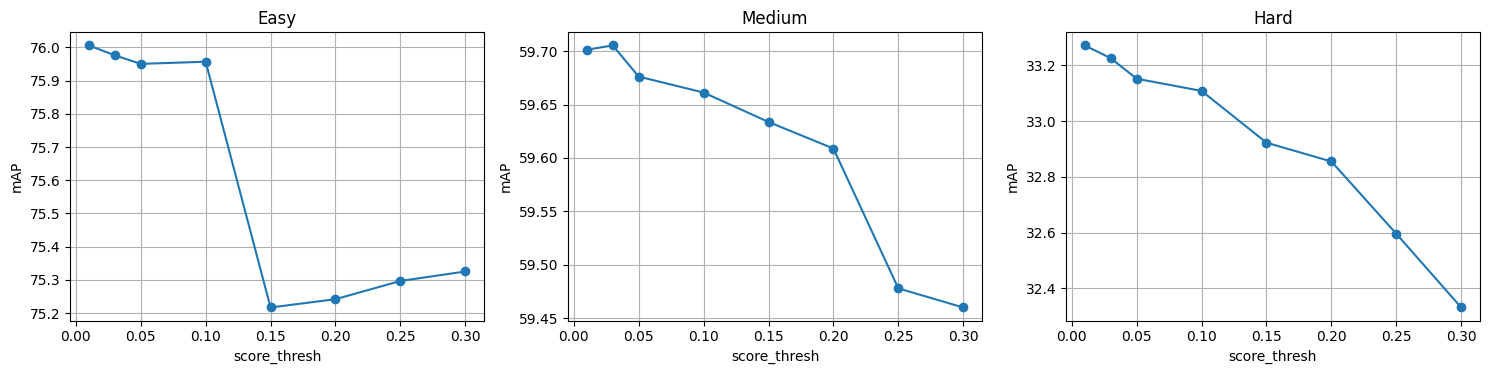

In [14]:
# Definir configuración de las métricas por nivel de dificultad
metrics = [
    ('map_easy_bbox', 'map_easy_bbox', 'map_easy_bbox', 'Easy'),
    ('map_medium_bbox', 'map_medium_bbox', 'map_medium_bbox', 'Medium'),
    ('map_hard_bbox', 'map_hard_bbox', 'map_hard_bbox', 'Hard'),
]

# Crear subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), sharex=True, sharey=False)

for i, (ax, (col1, col2, col3, title)) in enumerate(zip(axs.flat, metrics)):
    ax.set_title(title)
    ax.set_xlabel('min_area')
    if i < 3:
        df_score_thresh.plot(x='score_thresh', y=col1, ax=ax, label='mAP', marker='o', legend=False)
        ax.set_ylabel('mAP')
    ax.grid(True)

# plt.suptitle('Area mínima para la base de datos', fontsize=16, y=1.01)
plt.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.savefig('score_thresh_graph.png', dpi=300, bbox_inches='tight')
plt.show()

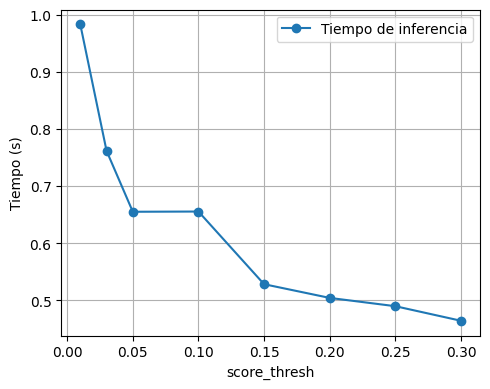

In [15]:
# Crear figura y ejes
fig, ax = plt.subplots(figsize=(5, 4))  # Tamaño proporcional a cada subplot anterior

# Graficar tiempo de inferencia
df_score_thresh.plot(x='score_thresh', y='inference_time', ax=ax, marker='o', color='tab:blue', label='Tiempo de inferencia')

# Configurar ejes y estilo
ax.set_xlabel('score_thresh')
ax.set_ylabel('Tiempo (s)')
ax.grid(True)
ax.legend()

# Ajustar diseño y mostrar
plt.tight_layout()
plt.savefig('score_thresh_time_graph.png', dpi=300, bbox_inches='tight')

plt.show()

In [16]:
# TEST iou_thresh
versions_ox = [38, 51, 52, 53, 54, 55, 56, 57, 58, 59]
df_iou_thresh_ox = df[df['version'].isin(versions_ox)]
df_iou_thresh_ox.sort_values('iou_thresh', inplace=True)

versions_pa = [61, 62, 63, 64, 65, 66, 67, 68, 69, 70]
df_iou_thresh_pa = df[df['version'].isin(versions_pa)]
df_iou_thresh_pa.sort_values('iou_thresh', inplace=True)

C:\Users\rdiaz\AppData\Local\Temp\ipykernel_19328\882739677.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iou_thresh_ox.sort_values('iou_thresh', inplace=True)
C:\Users\rdiaz\AppData\Local\Temp\ipykernel_19328\882739677.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iou_thresh_pa.sort_values('iou_thresh', inplace=True)


In [17]:
columns = [
    'version',
    'iou_thresh', 
    'map_easy_bbox', 'map_medium_bbox', 'map_hard_bbox', 
    'mp@1_easy_bbox', 'mp@1_medium_bbox', 'mp@1_hard_bbox', 
    'mp@5_easy_bbox', 'mp@5_medium_bbox', 'mp@5_hard_bbox', 
    'mp@10_easy_bbox', 'mp@10_medium_bbox', 'mp@10_hard_bbox',
    'inference_time'
]
df_iou_thresh_ox = df_iou_thresh_ox[columns]
df_iou_thresh_pa = df_iou_thresh_pa[columns]

In [18]:
df_iou_thresh = pd.merge(left=df_iou_thresh_ox, right=df_iou_thresh_pa, how='left', on='iou_thresh', suffixes = ['_ox', '_pa'])

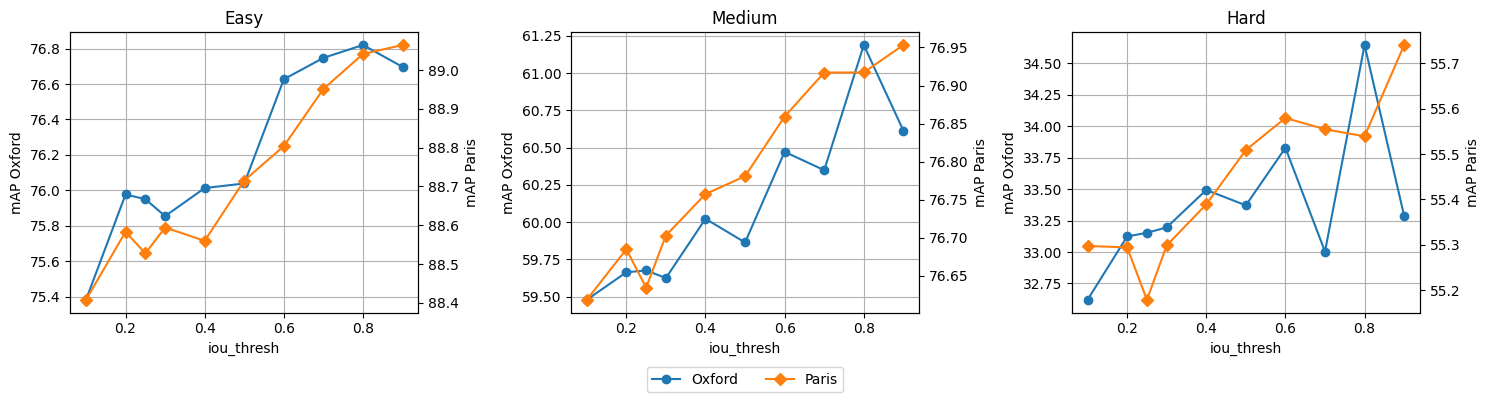

In [19]:
# Definir configuración de las métricas por nivel de dificultad
metrics = [
    ('map_easy_bbox_ox', 'map_easy_bbox_pa', 'Easy'),
    ('map_medium_bbox_ox', 'map_medium_bbox_pa', 'Medium'),
    ('map_hard_bbox_ox', 'map_hard_bbox_pa', 'Hard'),
]

# Crear subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), sharex=True, sharey=False)

# Para recolectar handles y labels de la leyenda
legend_handles = []
legend_labels = []
legend_added = False

for i, (ax, (col1, col2, title)) in enumerate(zip(axs.flat, metrics)):
    ax2 = ax.twinx()  # Crear segundo eje Y

    # Título y etiquetas
    ax.set_title(title)
    ax.set_xlabel('iou_thresh')

    # Elegir etiqueta Y según la métrica
    if i < 3:
        ylabel = 'mAP'

    ax.set_ylabel(f'{ylabel} Oxford')   # Eje izquierdo
    ax2.set_ylabel(f'{ylabel} Paris')   # Eje derecho

    # Graficar col1 en ax (izquierdo) y col2 en ax2 (derecho)
    line1 = df_iou_thresh.plot(x='iou_thresh', y=col1, ax=ax, label='Oxford', marker='o', color='tab:blue', legend=False)
    line2 = df_iou_thresh.plot(x='iou_thresh', y=col2, ax=ax2, label='Paris', marker='D', color='tab:orange', legend=False)

    # Capturar handles y labels solo una vez (suficiente con una instancia)
    if not legend_added:
        h1, l1 = ax.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        legend_handles.extend(h1 + h2)
        legend_labels.extend(l1 + l2)
        legend_added = True

    # Agregar grilla al eje principal
    ax.grid(True)

# Colocar la leyenda una vez fuera del grid
fig.legend(legend_handles, legend_labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.02))

plt.tight_layout(rect=[0, 0.05, 1, 0.99])
plt.savefig('iou_thresh_graph.png', dpi=300, bbox_inches='tight')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

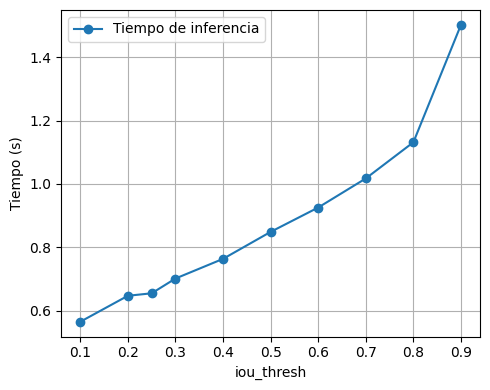

In [20]:
# Crear figura y ejes
fig, ax = plt.subplots(figsize=(5, 4))  # Tamaño proporcional a cada subplot anterior

# Graficar tiempo de inferencia
df_iou_thresh.plot(x='iou_thresh', y='inference_time_ox', ax=ax, marker='o', color='tab:blue', label='Tiempo de inferencia')

# Configurar ejes y estilo
ax.set_xlabel('iou_thresh')
ax.set_ylabel('Tiempo (s)')
ax.grid(True)
ax.legend()

# Ajustar diseño y mostrar
plt.tight_layout()
plt.savefig('iou_thresh_time_graph.png', dpi=300, bbox_inches='tight')

plt.show

In [21]:
# TEST rgem
versions_pa = [65, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105]
df_rgem_pa = df[df['version'].isin(versions_pa)]
df_rgem_pa.sort_values(['rgem_pr', 'rgem_size'], inplace=True)

versions_ox = [135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161]
df_rgem_ox = df[df['version'].isin(versions_ox)]
df_rgem_ox.sort_values(['rgem_pr', 'rgem_size'], inplace=True)

C:\Users\rdiaz\AppData\Local\Temp\ipykernel_19328\1495229610.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rgem_pa.sort_values(['rgem_pr', 'rgem_size'], inplace=True)
C:\Users\rdiaz\AppData\Local\Temp\ipykernel_19328\1495229610.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rgem_ox.sort_values(['rgem_pr', 'rgem_size'], inplace=True)


In [22]:
columns = [
    'version',
    'rgem_pr', 'rgem_size',
    'map_easy_bbox', 'map_medium_bbox', 'map_hard_bbox', 
]
df_rgem_pa = df_rgem_pa[columns]
df_rgem_ox = df_rgem_ox[columns]

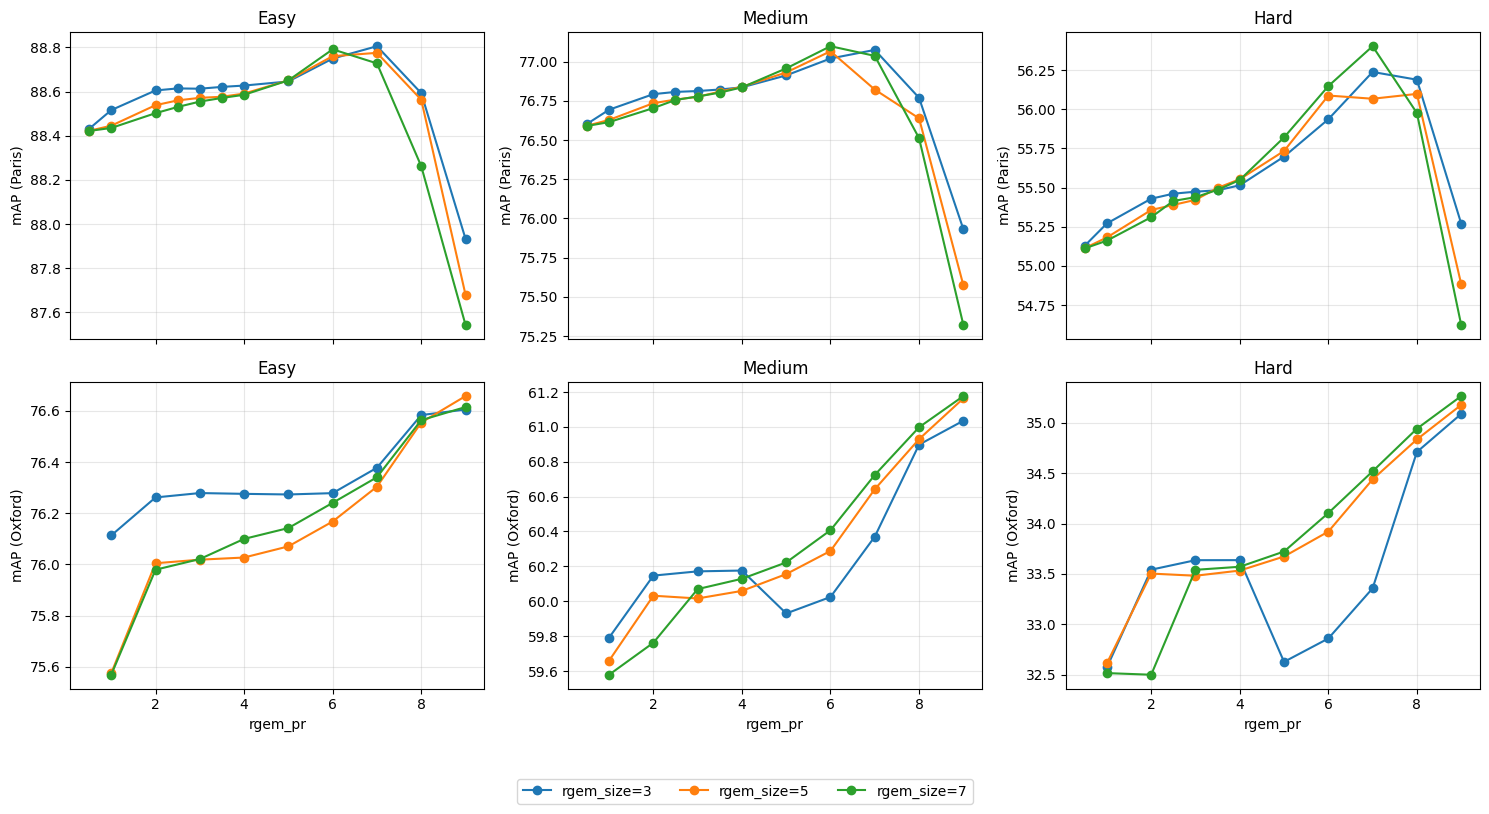

In [23]:
# Definir configuración de las métricas por nivel de dificultad
metrics = [
    ('map_easy_bbox', 'Easy'),
    ('map_medium_bbox', 'Medium'),
    ('map_hard_bbox', 'Hard'),
]

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Crear subplots: 1ª fila df_rgem_pa, 2ª fila df_rgem_ox
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 8), sharex=True, sharey=False)

# Paleta de colores y mapeo consistente por rgem_size (union entre ambos DF)
colors = plt.cm.tab10.colors
sizes_all = sorted(set(df_rgem_pa['rgem_size'].unique()).union(df_rgem_ox['rgem_size'].unique()))
color_map = {size: colors[i % len(colors)] for i, size in enumerate(sizes_all)}

# Helper para recorrer filas y dataframes
dfs_rgem = [df_rgem_pa, df_rgem_ox]

for row_idx, df_rgem in enumerate(dfs_rgem):
    for col_idx, (metric_col, title) in enumerate(metrics):
        ax = axs[row_idx, col_idx]
        ax.set_title(title)
        if row_idx == 1:
            ax.set_xlabel('rgem_pr')
            ax.set_ylabel('mAP (Oxford)')
        else:
            ax.set_ylabel('mAP (Paris)')
            
        ax.grid(True, alpha=0.3)

        for size in sorted(df_rgem['rgem_size'].unique()):
            subset = df_rgem[df_rgem['rgem_size'] == size].sort_values(by='rgem_pr')
            ax.plot(
                subset['rgem_pr'],
                subset[metric_col],
                marker='o',
                linestyle='-',
                label=f"rgem_size={size}",
                color=color_map[size]
            )

# Leyenda global (usando "proxy artists" para asegurar todos los tamaños)
legend_handles = [
    Line2D([0], [0], marker='o', linestyle='-', color=color_map[size], label=f'rgem_size={size}')
    for size in sizes_all
]
fig.legend(
    handles=legend_handles,
    loc='lower center',
    ncol=min(len(legend_handles), 6),
    bbox_to_anchor=(0.5, -0.02)
)

plt.tight_layout(rect=[0, 0.06, 1, 1])  # Deja espacio abajo para la leyenda
plt.savefig('rgem_graph.png', dpi=300, bbox_inches='tight')
plt.show()


In [24]:
# TEST gem_p
versions_ox = [162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172] # para 'rgem_pr': 8 y 'rgem_size': 5
df_gemp_ox = df[df['version'].isin(versions_ox)]
df_gemp_ox.sort_values(['gem_p', 'rgem_size'], inplace=True)

versions_pa = [173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183] # para 'rgem_pr': 8 y 'rgem_size': 5
df_gemp_pa = df[df['version'].isin(versions_pa)]
df_gemp_pa.sort_values('gem_p', inplace=True)

C:\Users\rdiaz\AppData\Local\Temp\ipykernel_19328\3494873681.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gemp_ox.sort_values(['gem_p', 'rgem_size'], inplace=True)
C:\Users\rdiaz\AppData\Local\Temp\ipykernel_19328\3494873681.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gemp_pa.sort_values('gem_p', inplace=True)


In [25]:
columns = [
    'gem_p', 'keep_full_img', 
    'map_easy', 'map_medium', 'map_hard', 
    'mp@1_easy', 'mp@1_medium', 'mp@1_hard', 
    'mp@5_easy', 'mp@5_medium', 'mp@5_hard', 
    'mp@10_easy', 'mp@10_medium', 'mp@10_hard',
    'map_easy_bbox', 'map_medium_bbox', 'map_hard_bbox', 
    'mp@1_easy_bbox', 'mp@1_medium_bbox', 'mp@1_hard_bbox', 
    'mp@5_easy_bbox', 'mp@5_medium_bbox', 'mp@5_hard_bbox', 
    'mp@10_easy_bbox', 'mp@10_medium_bbox', 'mp@10_hard_bbox'
]
df_gemp_ox = df_gemp_ox[columns]
df_gemp_pa = df_gemp_pa[columns]

In [26]:
df_gemp = pd.merge(left=df_gemp_ox, right=df_gemp_pa, how='left', on='gem_p', suffixes = ['_ox', '_pa'])

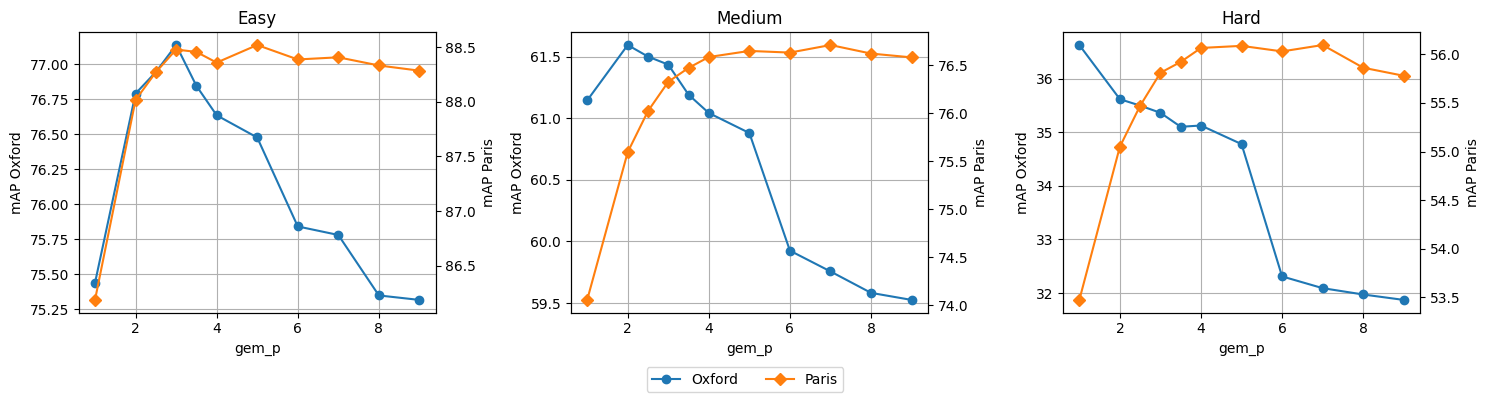

In [27]:
# Definir configuración de las métricas por nivel de dificultad
metrics = [
    ('map_easy_bbox_ox', 'map_easy_bbox_pa', 'Easy'),
    ('map_medium_bbox_ox', 'map_medium_bbox_pa', 'Medium'),
    ('map_hard_bbox_ox', 'map_hard_bbox_pa', 'Hard'),
]

# Crear subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), sharex=True, sharey=False)

# Para recolectar handles y labels de la leyenda
legend_handles = []
legend_labels = []
legend_added = False

for i, (ax, (col1, col2, title)) in enumerate(zip(axs.flat, metrics)):
    ax2 = ax.twinx()  # Crear segundo eje Y

    # Título y etiquetas
    ax.set_title(title)
    ax.set_xlabel('gem_p')

    # Elegir etiqueta Y según la métrica
    if i < 3:
        ylabel = 'mAP'

    ax.set_ylabel(f'{ylabel} Oxford')   # Eje izquierdo
    ax2.set_ylabel(f'{ylabel} Paris')   # Eje derecho

    # Graficar col1 en ax (izquierdo) y col2 en ax2 (derecho)
    line1 = df_gemp.plot(x='gem_p', y=col1, ax=ax, label='Oxford', marker='o', color='tab:blue', legend=False)
    line2 = df_gemp.plot(x='gem_p', y=col2, ax=ax2, label='Paris', marker='D', color='tab:orange', legend=False)

    # Capturar handles y labels solo una vez (suficiente con una instancia)
    if not legend_added:
        h1, l1 = ax.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        legend_handles.extend(h1 + h2)
        legend_labels.extend(l1 + l2)
        legend_added = True

    # Agregar grilla al eje principal
    ax.grid(True)

# Colocar la leyenda una vez fuera del grid
fig.legend(legend_handles, legend_labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.02))

plt.tight_layout(rect=[0, 0.05, 1, 0.99])
plt.savefig('gem_p_graph.png', dpi=300, bbox_inches='tight')
plt.show()

In [28]:
# TEST sgem_ps
versions_pa = [184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197] # paris
df_sgem_ps_pa = df[df['version'].isin(versions_pa)]
df_sgem_ps_pa.sort_values('sgem_ps', inplace=True)

versions_ox = [209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222] # oxford
df_sgem_ps_ox = df[df['version'].isin(versions_ox)]
df_sgem_ps_ox.sort_values('sgem_ps', inplace=True)

version_inf_pa = [198]
df_sgem_infinity_pa = df[df['version'].isin(version_inf_pa)]

version_inf_ox = [208]
df_sgem_infinity_ox = df[df['version'].isin(version_inf_ox)]

C:\Users\rdiaz\AppData\Local\Temp\ipykernel_19328\650471204.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sgem_ps_pa.sort_values('sgem_ps', inplace=True)
C:\Users\rdiaz\AppData\Local\Temp\ipykernel_19328\650471204.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sgem_ps_ox.sort_values('sgem_ps', inplace=True)


In [29]:
columns = [
    'sgem_ps', 'sgem_infinity', 'keep_full_img', 
    'map_easy_bbox', 'map_medium_bbox', 'map_hard_bbox', 
    'mp@1_easy_bbox', 'mp@1_medium_bbox', 'mp@1_hard_bbox', 
    'mp@5_easy_bbox', 'mp@5_medium_bbox', 'mp@5_hard_bbox', 
    'mp@10_easy_bbox', 'mp@10_medium_bbox', 'mp@10_hard_bbox'
]
df_sgem_ps_pa = df_sgem_ps_pa[columns]
df_sgem_ps_ox = df_sgem_ps_ox[columns]
df_sgem_infinity_pa = df_sgem_infinity_pa[columns]
df_sgem_infinity_ox = df_sgem_infinity_ox[columns]

In [30]:
df_sgem_ps = pd.merge(left=df_sgem_ps_ox, right=df_sgem_ps_pa, how='left', on='sgem_ps', suffixes = ['_ox', '_pa'])
df_sgem_infinity_ps = pd.merge(left=df_sgem_infinity_ox, right=df_sgem_infinity_pa, how='left', on='sgem_ps', suffixes = ['_ox', '_pa'])

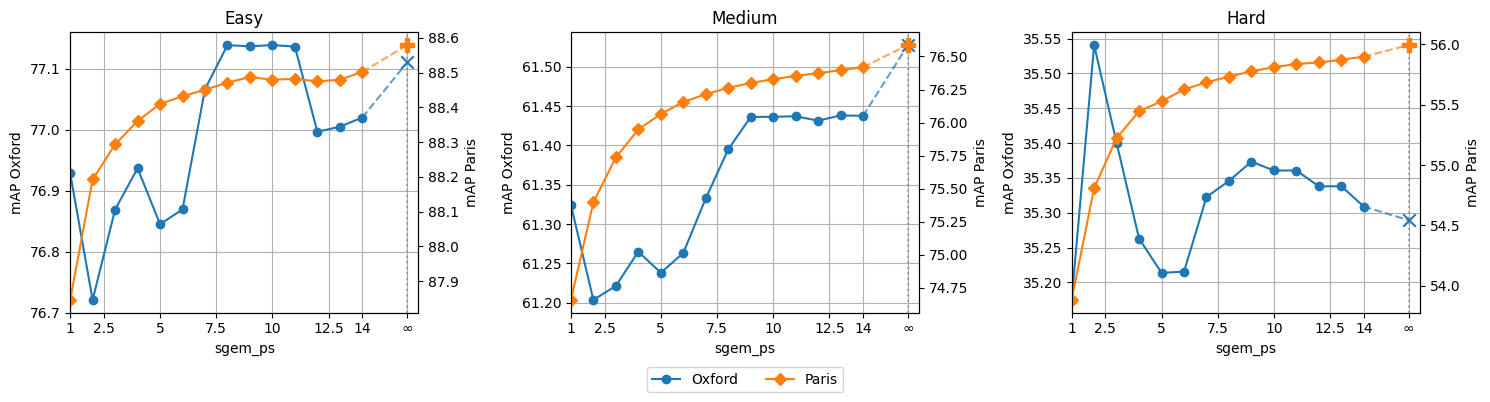

In [31]:
# --- Configuración de métricas ---
metrics = [
    ('map_easy_bbox_ox', 'map_easy_bbox_pa', 'Easy'),
    ('map_medium_bbox_ox', 'map_medium_bbox_pa', 'Medium'),
    ('map_hard_bbox_ox', 'map_hard_bbox_pa', 'Hard'),
]

# --- Subplots ---
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), sharex=True, sharey=False)

# --- Cálculo de la posición "∞" en X ---
x_vals = np.sort(df_sgem_ps['sgem_ps'].unique())
x_min, x_max = float(x_vals.min()), float(x_vals.max())
if len(x_vals) > 1:
    step = float(x_vals[-1] - x_vals[-2])
    if step == 0:
        step = 1.0
else:
    step = 1.0
x_inf = x_max + 2 * step

row_inf = df_sgem_infinity_ps.iloc[0]

# Para recolectar handles y labels de la leyenda
legend_handles = []
legend_labels = []
legend_added = False

for i, (ax, (col_ox, col_pa, title)) in enumerate(zip(axs.flat, metrics)):
    ax2 = ax.twinx()

    # Etiquetas
    ax.set_title(title)
    ax.set_xlabel('sgem_ps')
    ylabel = 'mAP'
    ax.set_ylabel(f'{ylabel} Oxford')
    ax2.set_ylabel(f'{ylabel} Paris')

    # Líneas principales
    line1 = df_sgem_ps.plot(
        x='sgem_ps', y=col_ox, ax=ax, label='Oxford', marker='o',
        color='tab:blue', legend=False
    )
    line2 = df_sgem_ps.plot(
        x='sgem_ps', y=col_pa, ax=ax2, label='Paris', marker='D',
        color='tab:orange', legend=False
    )

    # Puntos en el infinito
    y_inf_ox = float(row_inf[col_ox])
    y_inf_pa = float(row_inf[col_pa])

    ax.scatter([x_inf], [y_inf_ox], marker='x', s=80, color='tab:blue', zorder=5, label='_nolegend_')
    ax2.scatter([x_inf], [y_inf_pa], marker='P', s=90, color='tab:orange', zorder=5, label='_nolegend_')

    # Conectar con línea punteada desde el último punto
    last_x = df_sgem_ps['sgem_ps'].max()
    last_y_ox = df_sgem_ps.loc[df_sgem_ps['sgem_ps'] == last_x, col_ox].values[0]
    last_y_pa = df_sgem_ps.loc[df_sgem_ps['sgem_ps'] == last_x, col_pa].values[0]

    ax.plot([last_x, x_inf], [last_y_ox, y_inf_ox], linestyle='--', color='tab:blue', alpha=0.7)
    ax2.plot([last_x, x_inf], [last_y_pa, y_inf_pa], linestyle='--', color='tab:orange', alpha=0.7)

    # Línea vertical punteada para marcar ∞
    ax.axvline(x_inf, linestyle=':', color='gray', alpha=0.6)

    # Ajuste de ticks para incluir ∞
    curr_ticks = list(ax.get_xticks())
    all_ticks = sorted(set([t for t in curr_ticks if t >= x_min and t <= x_max] + [x_min, x_max]))
    if x_inf not in all_ticks:
        all_ticks.append(x_inf)
    ax.set_xticks(all_ticks)
    ax.set_xticklabels([
        '∞' if abs(t - x_inf) < 1e-9 else (str(int(t)) if float(t).is_integer() else f'{t:g}')
        for t in all_ticks
    ])
    ax.set_xlim(x_min, x_inf + 0.5 * step)

    ax.grid(True)

    if not legend_added:
        h1, l1 = ax.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        legend_handles.extend(h1 + h2)
        legend_labels.extend(l1 + l2)
        legend_added = True

# Leyenda global
fig.legend(legend_handles, legend_labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.02))

plt.tight_layout(rect=[0, 0.05, 1, 0.99])
plt.savefig('sgem_ps_graph.png', dpi=300, bbox_inches='tight')
plt.show()


In [32]:
df_sgem_ps

,sgem_ps,sgem_infinity_ox,keep_full_img_ox,map_easy_bbox_ox,map_medium_bbox_ox,map_hard_bbox_ox,mp@1_easy_bbox_ox,mp@1_medium_bbox_ox,mp@1_hard_bbox_ox,mp@5_easy_bbox_ox,...,map_hard_bbox_pa,mp@1_easy_bbox_pa,mp@1_medium_bbox_pa,mp@1_hard_bbox_pa,mp@5_easy_bbox_pa,mp@5_medium_bbox_pa,mp@5_hard_bbox_pa,mp@10_easy_bbox_pa,mp@10_medium_bbox_pa,mp@10_hard_bbox_pa
0,1.0,False,1,76.928903,61.324488,35.174878,97.058824,95.714286,74.285714,86.838235,...,53.883532,98.571429,98.571429,91.428571,96.095238,97.714286,90.571429,94.333333,96.142857,88.142857
1,2.0,False,1,76.720704,61.203637,35.540688,97.058824,95.714286,77.142857,87.279412,...,54.808759,98.571429,98.571429,91.428571,96.095238,97.714286,91.142857,94.333333,96.142857,88.571429
2,3.0,False,1,76.868822,61.221420,35.400222,97.058824,95.714286,77.142857,87.573529,...,55.222583,98.571429,98.571429,90.000000,95.809524,97.428571,91.142857,93.952381,96.142857,88.714286
3,4.0,False,1,76.936791,61.265024,35.262949,97.058824,95.714286,74.285714,87.352941,...,55.444854,98.571429,98.571429,90.000000,95.809524,97.428571,91.142857,93.809524,96.142857,88.857143
4,5.0,False,1,76.845075,61.238163,35.213726,97.058824,95.714286,74.285714,86.691176,...,55.527484,98.571429,98.571429,90.000000,95.523810,97.142857,91.142857,93.666667,96.142857,88.857143
5,6.0,False,1,76.869135,61.263232,35.215440,97.058824,95.714286,74.285714,86.985294,...,55.624911,98.571429,98.571429,90.000000,95.523810,97.428571,91.142857,93.523810,96.142857,88.857143
6,7.0,False,1,77.066327,61.332560,35.322529,97.058824,95.714286,75.714286,86.985294,...,55.684521,98.571429,98.571429,90.000000,95.523810,97.428571,91.142857,93.523810,96.142857,88.857143
7,8.0,False,1,77.138760,61.394931,35.345620,97.058824,95.714286,75.714286,87.205882,...,55.731152,98.571429,98.571429,91.428571,95.523810,97.428571,91.428571,93.523810,96.142857,89.000000
8,9.0,False,1,77.136816,61.436189,35.373304,97.058824,95.714286,75.714286,87.205882,...,55.775539,98.571429,98.571429,91.428571,95.523810,97.428571,91.428571,93.523810,96.142857,89.000000
9,10.0,False,1,77.138957,61.436372,35.360621,97.058824,95.714286,75.714286,87.205882,...,55.809647,98.571429,98.571429,91.428571,95.523810,97.428571,91.428571,93.238095,96.000000,89.000000


In [38]:
columns = [
    'map_easy', 'map_medium', 'map_hard', 
    'mp@1_easy', 'mp@1_medium', 'mp@1_hard', 
    'mp@5_easy', 'mp@5_medium', 'mp@5_hard', 
    'mp@10_easy', 'mp@10_medium', 'mp@10_hard'
]

In [39]:
df[df['version']==198][columns] # paris

,map_easy,map_medium,map_hard,mp@1_easy,mp@1_medium,mp@1_hard,mp@5_easy,mp@5_medium,mp@5_hard,mp@10_easy,mp@10_medium,mp@10_hard
201,88.206414,75.95386,54.949663,97.142857,98.571429,92.857143,95.809524,97.428571,91.428571,93.952381,96.714286,88.285714


In [40]:
df[df['version']==208][columns] # oxford

,map_easy,map_medium,map_hard,mp@1_easy,mp@1_medium,mp@1_hard,mp@5_easy,mp@5_medium,mp@5_hard,mp@10_easy,mp@10_medium,mp@10_hard
211,76.251269,61.444691,35.784696,97.058824,95.714286,72.857143,84.926471,86.761905,59.142857,80.514706,82.190476,49.428571


In [36]:
df[df['version']==0][columns] # oxford

,map_easy,map_medium,map_hard,mp@1_easy,mp@1_medium,mp@1_hard,mp@5_easy,mp@5_medium,mp@5_hard,mp@10_easy,mp@10_medium,mp@10_hard
0,75.487132,58.685715,30.344432,97.058824,95.714286,64.285714,84.044118,81.809524,53.428571,78.455882,77.190476,44.142857


In [37]:
df[df['version']==223][columns] # paris

,map_easy,map_medium,map_hard,mp@1_easy,mp@1_medium,mp@1_hard,mp@5_easy,mp@5_medium,mp@5_hard,mp@10_easy,mp@10_medium,mp@10_hard
226,88.189083,76.668265,55.086748,97.142857,98.571429,92.857143,94.952381,97.714286,92.0,93.380952,97.285714,89.428571
